In [5]:
import glob
import pandas as pd
import numpy as np
import os
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use(["seaborn-whitegrid", "seaborn-poster"])

## Cumulative Max Accuracy

We see that HyperSched is able to obtain a significantly higher accuracy for the trained model given a deadline.

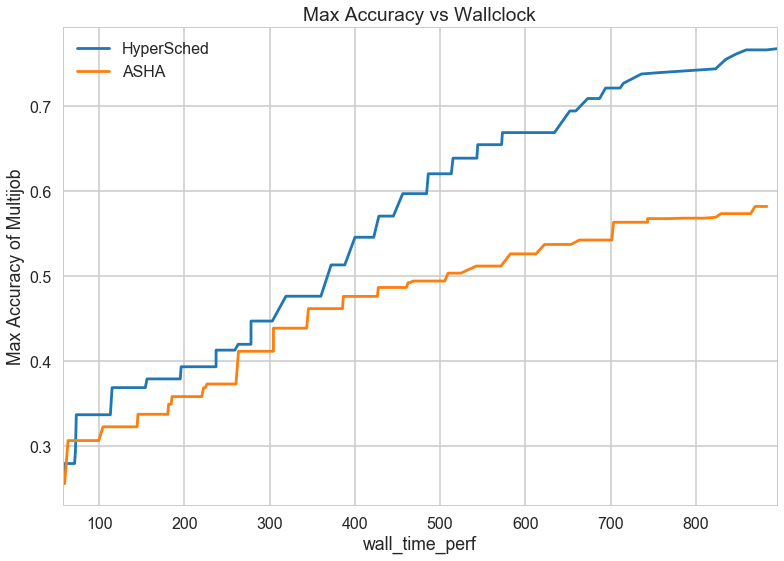

In [11]:
def get_dataframes(data_dir):
    hyper_csvs = glob.glob(os.path.join(data_dir, "**/progress.csv"), recursive=True)
    hyper_dfs = [pd.read_csv(x) for x in hyper_csvs if os.path.getsize(x) > 0]
    start = min([hdf.timestamp[0] - hdf.time_this_iter_s[0] - hdf.setup_time[0]  for hdf in hyper_dfs]) 
    
    for hdf in hyper_dfs:
        hdf["wall_time_perf"] = hdf.timestamp - start
    return hyper_dfs

def get_walltime_cummax_df(hyper_dfs):
    concatenated = pd.concat([hdf[["wall_time_perf", "mean_accuracy"]] for hdf in hyper_dfs])
    return concatenated.sort_values("wall_time_perf").cummax()

df_list_hyper = get_dataframes("./HyperSched*")
hyper = get_walltime_cummax_df(df_list_hyper)
ax = hyper.plot("wall_time_perf", "mean_accuracy", label="HyperSched")

df_list_asha = get_dataframes("./Async*")
asha = get_walltime_cummax_df(df_list_asha)
asha.plot("wall_time_perf", "mean_accuracy", label="ASHA", ax=ax)
ax.set_ylabel("Max Accuracy of Multijob")
ax.set_title("Max Accuracy vs Wallclock")
ax.figure.savefig("./max-accuracy-30j-900.pdf")

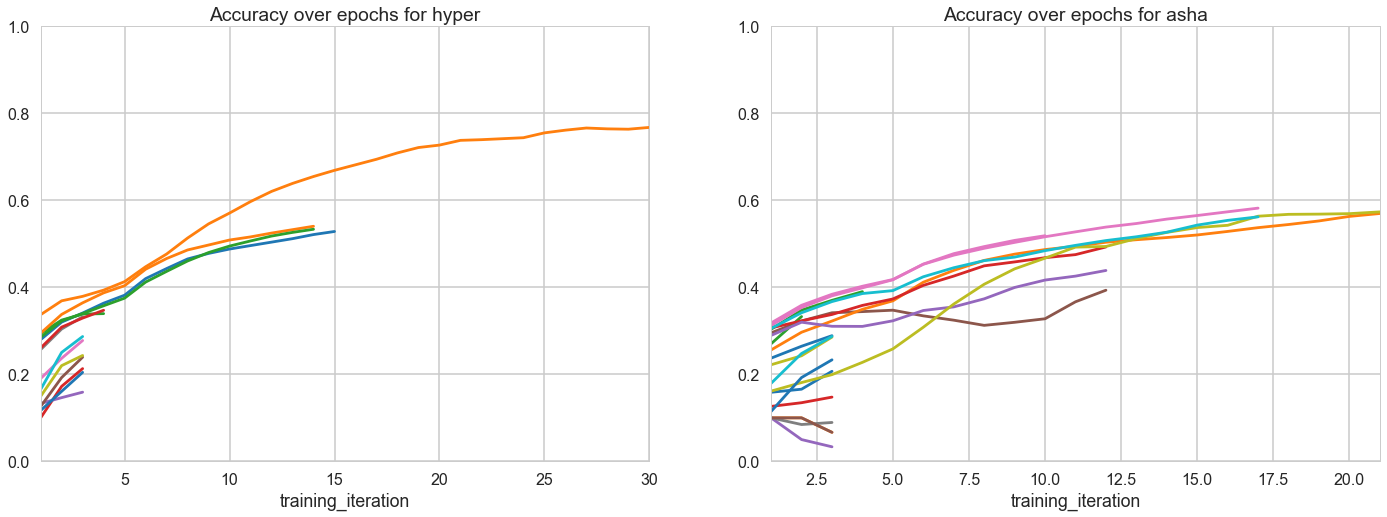

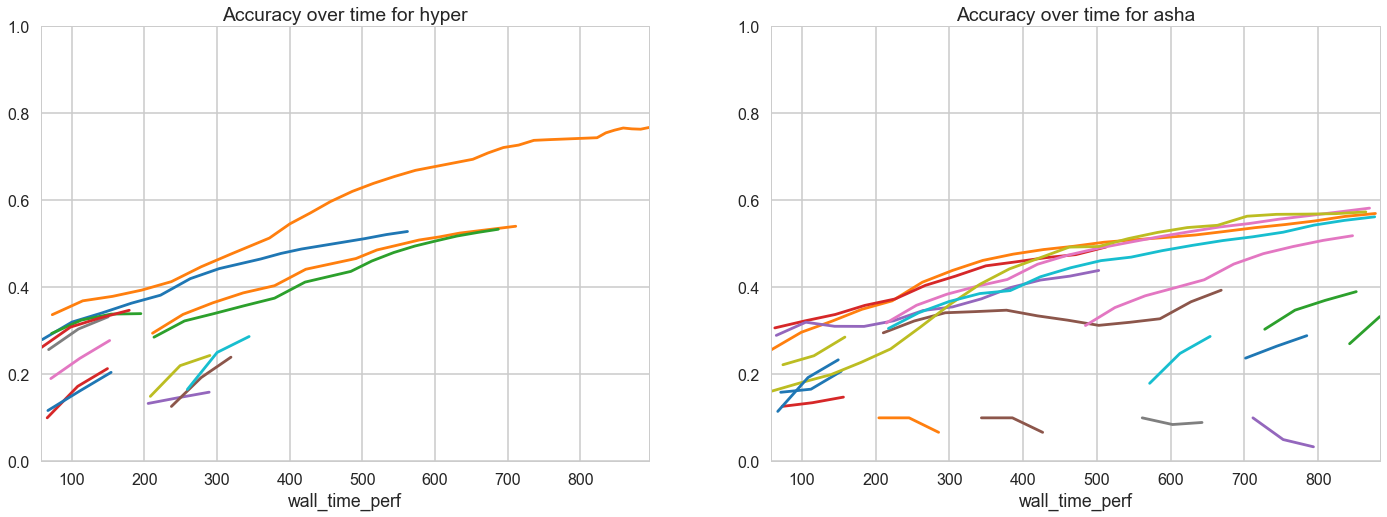

In [6]:
def plot_accuracy(list_of_schedules, schedule_names, metric):
    fig, ax_list = plt.subplots(1, len(list_of_schedules))
    
    for ax, schedule_df_list, schedule_name in zip(ax_list, list_of_schedules, schedule_names):
        for df in schedule_df_list:
            df.plot(metric, "mean_accuracy", ax=ax, legend=False)
    
        ax.set_ylim([0, 1])
    return fig, ax_list
    
schedules = ["hyper",  "asha"]
fig, ax_list = plot_accuracy([df_list_hyper, df_list_asha], schedules, "training_iteration") 
[ax.set_title(f"Accuracy over epochs for {schedule_name}") for ax, schedule_name in zip(ax_list, schedules)]
fig.set_size_inches(24, 8)

fig, ax_list = plot_accuracy([df_list_hyper, df_list_asha], schedules, "wall_time_perf") 
[ax.set_title(f"Accuracy over time for {schedule_name}") for ax, schedule_name in zip(ax_list, schedules)]
fig.set_size_inches(24, 8)

### Resource Allocation

Resource allocation for both jobs is given below. 

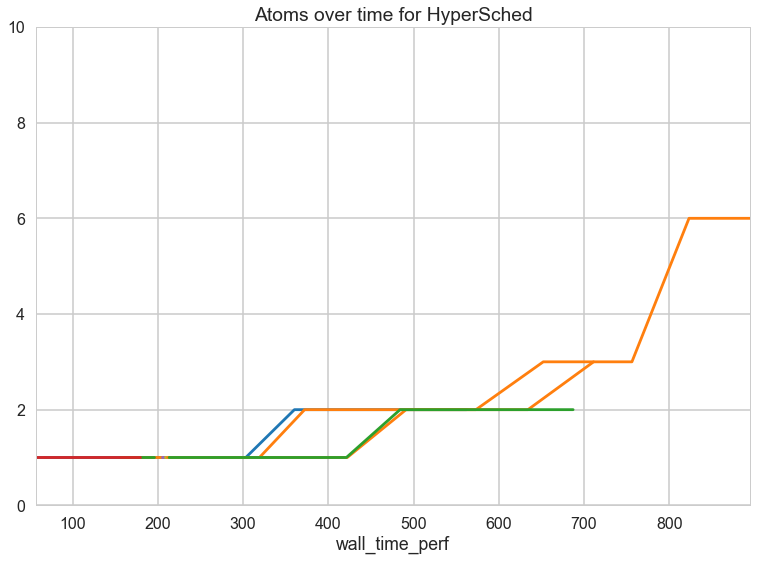

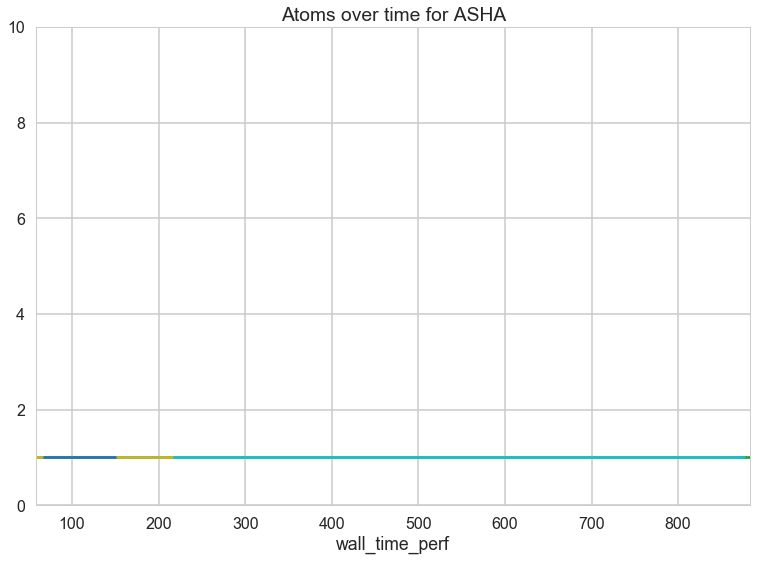

In [7]:
def plot_atoms(df_list, title):
    ax = None
    for df in df_list:
        ax = df.plot("wall_time_perf", "atoms", ax=ax, legend=False)
    
    ax.set_ylim([0, 10])
    ax.set_title(title)

plot_atoms(df_list_hyper, "Atoms over time for HyperSched")
plot_atoms(df_list_asha, "Atoms over time for ASHA")